In [1]:
import torch
import torchvision
import os, sys, matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('../src/')
from vae import VAE_small


In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 42
torch.manual_seed(random_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=True, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=False, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True, pin_memory=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

0 tensor(3)
784


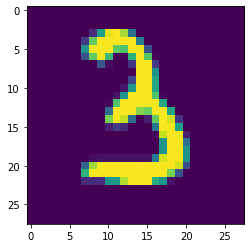

In [ ]:
print(batch_idx, example_targets[0])
print(example_data.numpy()[0][0].size)
plt.imshow(example_data.numpy()[0][0])

In [ ]:
layers = [256, 64, 16]
epochs = [100, 300]
# regularization = ('weight_decay', 0.05)
loss_threshold = 0.01

In [ ]:
model = VAE_small([28,28], device, layers)

In [ ]:
train_err, test_err = model.train(train_loader, epochs=epochs, test_data=test_loader, loss_threshold=loss_threshold)

  0%|          | 0/300 [00:00<?, ?it/s]

starting training...


 25%|██▌       | 76/300 [17:50<53:36, 14.36s/it]  

In [ ]:
plt.plot(train_err)
plt.plot(test_err)

In [ ]:
model.encode(example_data.numpy()[0][0].reshape([784]))